In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

# visualization
import pydotplus
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.decomposition import FactorAnalysis, PCA
from lightgbm.sklearn import LGBMClassifier


#preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder


import warnings
warnings.filterwarnings('ignore')


C:\ProgramData\Anaconda3\envs\courses\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I. Acquire data

The Python Pandas packages helps us work with our datasets. We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [3]:
train_data = pd.read_csv('.\\titanic\\train.csv')
test_data = pd.read_csv('.\\titanic\\test.csv')
test_data.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## a. Preprocessing

In [31]:
train_df = train_data.copy()
test_df = test_data.copy()
y = train_data['Survived']

full_data = [train_df, test_df]

for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    #dataset['IsAlone'] = 0
    #dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    #dataset['Ticket'] = dataset['Ticket'].apply(lambda x : x.isdigit()).astype(int)

    def family_group(size):
        a = ''
       # if (size <= 1):
       #     a = 'loner'
        if (size <= 5): #4
            a = 'small'
        else:
            a = 'large'
        return a
    
    dataset['FamilyGroup'] = dataset['FamilySize'].map(family_group)

    dataset['Title'] = dataset['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())
    dataset['Title'] = dataset['Title'].replace(['Lady','the Countess', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Gui et parenthese
    dataset['parenthese'] = dataset['Name'].apply(lambda x : '(' in(x)  ).astype(int)
    dataset['guill'] = dataset['Name'].apply(lambda x : '"' in(x)  ).astype(int)
    dataset['Random'] = np.random.randn(dataset.shape[0])
    
    
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
        
    dataset['Embarked'] = dataset['Embarked'].fillna('C')   


    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

    def cabin_estimator(i):
        """Grouping cabin feature by the first letter"""
        a = 0
        if i<16:
            a = "G"
        elif i>=16 and i<27:
            a = "F"
        elif i>=27 and i<38:
            a = "T"
        elif i>=38 and i<47:
            a = "A"
        elif i>= 47 and i<53:
            a = "E"
        elif i>= 53 and i<54:
            a = "D"
        elif i>=54 and i<116:
            a = 'C'
        else:
            a = "B"
        return a

    dataset['Cabin_alpha'] = dataset['Cabin'].fillna('N')
    dataset['Cabin_alpha'] = dataset['Cabin_alpha'].apply( lambda x : x.split()[0][0] )
    
    dataset[dataset['Cabin_alpha']=='N']['Cabin_alpha'] = dataset[dataset['Cabin_alpha']=='N']['Fare'].apply(cabin_estimator)
  
    dataset['calculated_fare'] = dataset.Fare/dataset.FamilySize
    def fare_group(fare):
        a= ''
        if fare == 0.0:
            a='Invited'
        elif fare <= 7.25:
            a = 'Very_low'
        elif fare <= 8.3:
            a = 'low'
        elif fare <= 23.667:
            a = 'mid'
        elif fare <= 40:
            a = 'high'
        else:
            a = "very_high"
        return a

    dataset['fare_group'] = dataset['calculated_fare'].map(fare_group)

train_df.drop(['Name', 'PassengerId', 'Ticket', 'Survived','Cabin'], axis=1, inplace=True)
test_df.drop(['Name', 'PassengerId','Ticket', 'Cabin'], axis=1, inplace=True)

#features_enc
mask_categorical = (train_df.dtypes=='O').reset_index()
cat_features = mask_categorical[mask_categorical[0]==True]['index'].values

train_df = pd.get_dummies(train_df, columns=cat_features, drop_first=False)
test_df = pd.get_dummies(test_df, columns=cat_features, drop_first=False)

## rearranging the columns so that I can easily use the dataframe to predict the missing age values. 
train_df = pd.concat([train_df[["Age", "Sex","SibSp","Pclass"]], train_df.loc[:,"Parch":]], axis=1)
test_df = pd.concat([test_df[["Age", "Sex","SibSp","Pclass"]], test_df.loc[:,"Parch":]], axis=1)

def completing_age(df):
    ## gettting all the features except survived
    age_df = df.loc[:,"Age":] 
    
    temp_train = age_df.loc[age_df.Age.notnull()] ## df with age values
    temp_test = age_df.loc[age_df.Age.isnull()] ## df without age values
    
    y = temp_train.Age.values ## setting target variables(age) in y 
    x = temp_train.loc[:, "Sex":].values
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs=-1)
    rfr.fit(x, y)
    
    predicted_age = rfr.predict(temp_test.loc[:, "Sex":])
    df.loc[df.Age.isnull(), "Age"] = predicted_age
    
    return df

## Implementing the completing_age function in both train and test dataset. 
train_df = completing_age(train_df)
test_df = completing_age(test_df);

def cat_age(x):
    a=None
    if x <=2:
        a='Baby_1'
    elif x <=8:
        a='Baby_2'
    elif x <=11:
        a='Baby_3'
    elif x <=13:
        a='Baby_4'
    elif x <=19:
        a='Baby_5'
    elif x <=25:
        a='Baby_6'
    elif x <=30:
        a='Baby_7'
    elif x <=40:
        a='Baby_8'
    elif x <=60:
        a='Baby_9'
    else:
        a='Baby_10'
    return a

train_df['Age_cat'] = train_df['Age'].apply(lambda x:cat_age(x))
test_df['Age_cat'] = test_df['Age'].apply(lambda x:cat_age(x))

train_df['Pclass_cat'] = train_df['Pclass'].map({1:'First',2:'Second',3:'Third'})
test_df['Pclass_cat'] = test_df['Pclass'].map({1:'First',2:'Second',3:'Third'})


#features_enc
mask_categorical = (train_df.dtypes=='O').reset_index()
cat_features = mask_categorical[mask_categorical[0]==True]['index'].values

train_df = pd.get_dummies(train_df, columns=cat_features, drop_first=False)
test_df = pd.get_dummies(test_df, columns=cat_features, drop_first=False)


train_df.drop(['Title_Mr', 'FamilySize', 'Embarked_S','calculated_fare','Pclass_cat_Third','Cabin_alpha_N','Cabin_alpha_T','FamilyGroup_small','Pclass_cat_First'], axis=1, inplace=True)
test_df.drop(['Title_Mr','FamilySize','Embarked_S','calculated_fare','Pclass_cat_Third','Cabin_alpha_N','FamilyGroup_small','Pclass_cat_First'], axis=1, inplace=True)


In [32]:
#features_enc
mask_numerical = (train_df.dtypes!='O').reset_index()
new_features = mask_numerical[mask_numerical[0]==True]['index'].values
new_features

array(['Age', 'Sex', 'SibSp', 'Pclass', 'Parch', 'Fare', 'Name_length',
       'Has_Cabin', 'parenthese', 'guill', 'Random', 'Embarked_C',
       'Embarked_Q', 'FamilyGroup_large', 'Title_Master', 'Title_Miss',
       'Title_Mrs', 'Title_Rare', 'Cabin_alpha_A', 'Cabin_alpha_B',
       'Cabin_alpha_C', 'Cabin_alpha_D', 'Cabin_alpha_E', 'Cabin_alpha_F',
       'Cabin_alpha_G', 'fare_group_Invited', 'fare_group_Very_low',
       'fare_group_high', 'fare_group_low', 'fare_group_mid',
       'fare_group_very_high', 'Age_cat_Baby_1', 'Age_cat_Baby_10',
       'Age_cat_Baby_2', 'Age_cat_Baby_3', 'Age_cat_Baby_4',
       'Age_cat_Baby_5', 'Age_cat_Baby_6', 'Age_cat_Baby_7',
       'Age_cat_Baby_8', 'Age_cat_Baby_9', 'Pclass_cat_Second'],
      dtype=object)

## Covariance shift

- https://github.com/erlendd/covariate-shift-adaption/blob/master/Supervised%20classification%20by%20covariate%20shift%20adaption.ipynb
- https://tiao.io/post/density-ratio-estimation-for-kl-divergence-minimization-between-implicit-distributions/

- https://gsarantitis.wordpress.com/2019/03/26/machine-learning-feature-selection-a-collection-of-91-techniques/
- https://towardsdatascience.com/how-dis-similar-are-my-train-and-test-data-56af3923de9b
- https://medium.com/@alon.lek/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1
- https://en.wikipedia.org/wiki/Sensitivity_and_specificity
- https://github.com/hoxo-m/densratio_py
- https://en.wikipedia.org/wiki/Accuracy_and_precision
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

- https://medium.com/@alon.lek/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1
- https://en.wikipedia.org/wiki/Sensitivity_and_specificity

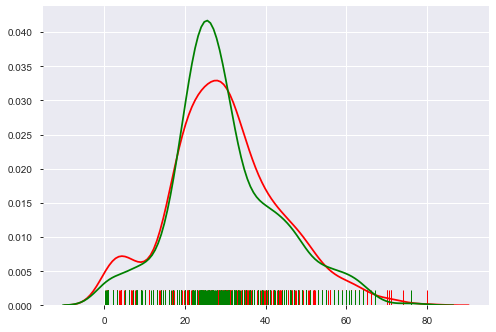

In [6]:
sns.distplot(train_df.Age.values,color='r',rug=True,hist=False)
sns.distplot(test_df.Age.values,color='g',rug=True,hist=False)

In [7]:
train_sample = train_df.copy()
train_sample['Target'] = 1
test_sample = test_df.copy()
test_sample['Target'] = 0
cov_shift = pd.concat([train_sample,test_sample], axis=0,ignore_index=True)
y_shift = cov_shift['Target']
cov_shift = cov_shift.drop('Target',axis=1)

### Individual variables

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

clf =  RandomForestClassifier(n_estimators=150, max_depth=2)

predictions = np.zeros(y_shift.shape)

for feature in new_features : 
    cv = StratifiedKFold(n_splits=20,shuffle=True)

    for fold, (train_idx, test_idx) in enumerate(cv.split(cov_shift,y_shift)):
        X_train, X_test = cov_shift.loc[train_idx], cov_shift.loc[test_idx]
        y_train, y_test = y_shift[train_idx], y_shift[test_idx]

        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)[:, 1]
        predictions[test_idx] = probs
    
    print ('Feature {%f}: ROC-AUC {%f}',feature, roc_auc_score(y_shift, predictions))

Feature {%f}: ROC-AUC {%f} Age 0.5442624007217308
Feature {%f}: ROC-AUC {%f} Sex 0.5407316117044985
Feature {%f}: ROC-AUC {%f} SibSp 0.5413773567681064
Feature {%f}: ROC-AUC {%f} Pclass 0.5386426734114134
Feature {%f}: ROC-AUC {%f} Parch 0.5267762688017872
Feature {%f}: ROC-AUC {%f} Fare 0.5381566864820453
Feature {%f}: ROC-AUC {%f} Name_length 0.5387326212685064
Feature {%f}: ROC-AUC {%f} Has_Cabin 0.5542801754922968
Feature {%f}: ROC-AUC {%f} parenthese 0.537454556194588
Feature {%f}: ROC-AUC {%f} guill 0.5365322550330525
Feature {%f}: ROC-AUC {%f} Random 0.5302949752710518
Feature {%f}: ROC-AUC {%f} Embarked_C 0.5373807184014521
Feature {%f}: ROC-AUC {%f} Embarked_Q 0.5500942438741482
Feature {%f}: ROC-AUC {%f} FamilyGroup_large 0.5407235566725199
Feature {%f}: ROC-AUC {%f} Title_Master 0.5322469780205027
Feature {%f}: ROC-AUC {%f} Title_Miss 0.5215821156809992
Feature {%f}: ROC-AUC {%f} Title_Mrs 0.5415075797850918
Feature {%f}: ROC-AUC {%f} Title_Rare 0.5372854005230401
Feature {%

### By samples

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits=20,shuffle=True)
clf =  RandomForestClassifier(n_estimators=150, max_depth=2)

predictions = np.zeros(y_shift.shape)

for fold, (train_idx, test_idx) in enumerate(cv.split(cov_shift,y_shift)):
    print ('Training discriminator model for fold {}'.format(fold))
    X_train, X_test = cov_shift.loc[train_idx], cov_shift.loc[test_idx]
    y_train, y_test = y_shift[train_idx], y_shift[test_idx]
        
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1]
    predictions[test_idx] = probs
    
print ('ROC-AUC for Train and Test distributions:', roc_auc_score(y_shift, predictions), accuracy_score(y_shift,(predictions>=0.5).astype(int)))

Training discriminator model for fold 0
Training discriminator model for fold 1
Training discriminator model for fold 2
Training discriminator model for fold 3
Training discriminator model for fold 4
Training discriminator model for fold 5
Training discriminator model for fold 6
Training discriminator model for fold 7
Training discriminator model for fold 8
Training discriminator model for fold 9
Training discriminator model for fold 10
Training discriminator model for fold 11
Training discriminator model for fold 12
Training discriminator model for fold 13
Training discriminator model for fold 14
Training discriminator model for fold 15
Training discriminator model for fold 16
Training discriminator model for fold 17
Training discriminator model for fold 18
Training discriminator model for fold 19
ROC-AUC for Train and Test distributions: 0.5615834044861158 0.680672268907563


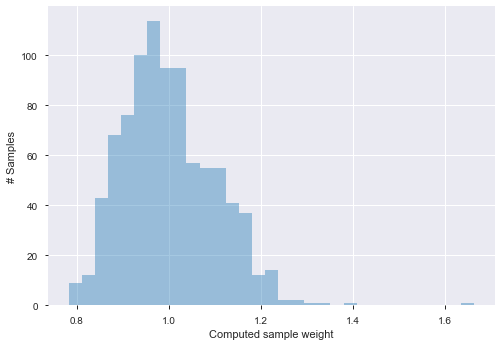

In [12]:
# first, isolate the training part (recall we joined them above)
predictions_Z = predictions[:len(train_sample)]
my_weights = (1./predictions_Z) - 1. 
my_weights /= np.mean(my_weights) # we do this to re-normalize the computed log-loss
plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')
sns.distplot(my_weights, kde=False)

## Correlation study

In [33]:
plt.figure(figsize=(10,10))
#train_df[['Title_Mr','Sex']].corr()
#train_df[['FamilySize','SibSp']].corr() #.89
#train_df[['Embarked_S','Embarked_C']].corr() # -0.78
#train_df[['Title_Miss','Sex']].corr() # -0.69
#train_df[['Pclass','Age_cat']].corr()

#_= sns.heatmap(train_df.corr()[train_df.corr() > 0.7])
#_= sns.heatmap(train_df.corr()[train_df.corr() < -0.6])
#_= sns.heatmap(train_df.corr())
#train_df[['FamilySize','Survived']].corr() #.89

#train_df.corr()

KeyError: "['FamilySize'] not in index"

<Figure size 720x720 with 0 Axes>

## Model construction

In [34]:
X = train_df[new_features]
sub_test = test_df[new_features]

### Data Scaling

In [126]:
#Not the best way but for this example, 
scl = MinMaxScaler()
scl.fit(pd.concat((X,sub_test),axis=0))
X_scaled_minmax = pd.DataFrame(data=scl.transform(X),columns=X.columns)
X_test_scaled_minmax = pd.DataFrame(data=scl.transform(sub_test),columns=X.columns)


scl = StandardScaler()
scl.fit(pd.concat((X,sub_test),axis=0))
X_scaled_std = pd.DataFrame(data=scl.transform(X),columns=X.columns)
X_test_scaled_std = pd.DataFrame(data=scl.transform(sub_test),columns=X.columns)

scl = RobustScaler()
scl.fit(pd.concat((X,sub_test),axis=0))
X_scaled_rob = pd.DataFrame(data=scl.transform(X),columns=X.columns)
X_test_scaled_rob = pd.DataFrame(data=scl.transform(sub_test),columns=X.columns)

### Principal Component Analysis
- #https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


In [40]:
from sklearn.decomposition import PCA

pca_best = ['PCA_'+str(fold) for fold in range(1,5)]

pca = PCA(n_components=4)
pca.fit(X)
X_pca = pd.DataFrame(data=pca.transform(X),columns=pca_best)

sub_test_pca = pd.DataFrame(data=pca.transform(sub_test),columns=pca_best)
np.round(pca.explained_variance_,2)

array([2.47365e+03, 1.88510e+02, 8.42200e+01, 1.25000e+00])

Text(0, 0.5, 'cumulative explained variance')

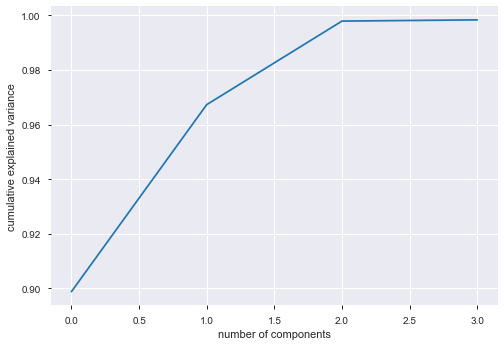

In [41]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

###  Factor Analysis
- #https://www.datacamp.com/community/tutorials/introduction-factor-analysis
- https://www.statology.org/a-guide-to-bartletts-test-of-sphericity/
- https://easystats.github.io/parameters/reference/check_sphericity.html
- https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
- https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/
- https://www.kaggle.com/reisel/how-to-handle-correlated-features
- https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
- Latent variable
- https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html

Bartlett’s Test of Sphericity compares an observed correlation matrix to the identity matrix. Essentially it checks to see if there is a certain redundancy between the variables that we can summarize with a few number of factors. 

In [77]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo
from factor_analyzer import FactorAnalyzer
  
chi_square_value,p_value = calculate_bartlett_sphericity(X)
print("Bartlet Test(p_value sould be near from 0): ",chi_square_value, p_value)

kmo_all,kmo_model=calculate_kmo(X)
print("KMO Test (should be > 0.6):", kmo_model)

Bartlet Test(p_value sould be near from 0):  80730.83670760643 0.0
KMO Test (should be > 0.6): 0.2775898758107305


In [81]:
fa_best = ['FA_'+str(fold) for fold in range(1,22)]

fa = FactorAnalyzer(rotation="varimax",n_factors=27)
fa.fit(X)

#Check Eigenvalues
ev, v = fa.get_eigenvalues()
#print("Contribution is the initial variables\n", fa.loadings_)
print("Eigne values: Important are > 1:\n", ev[np.round(ev,2)>0.9])
#Case 1 : only latent variables
X_fa = fa.transform(X)
sub_test_fa = fa.transform(sub_test)

Eigne values: Important are > 1:
 [4.72099974 3.83035458 2.74339092 2.28937402 2.00868269 1.65992628
 1.41923713 1.39392554 1.30212918 1.26370854 1.24407767 1.1651673
 1.13772021 1.0954615  1.06442889 1.04693993 1.04455677 1.01311604
 0.99692704 0.96835175 0.91679959]


Text(0, 0.5, 'cumulative  variance')

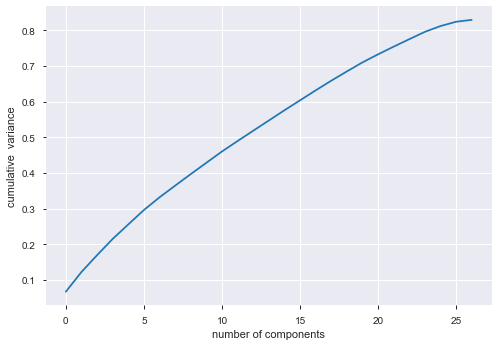

In [79]:
#https://www.datacamp.com/community/tutorials/introduction-factor-analysis
# 1. Sum of squared loadings (variance)
# 2. Proportional variance
# 3. Cumulative variance
a,b,c = fa.get_factor_variance()
#plt.plot(np.cumsum(a))
#plt.plot(np.cumsum(b))
plt.plot(c)

-= plt.xlabel('number of components')
-= plt.ylabel('cumulative variance')

### Feature selection

Often in data science we have hundreds or even millions of features and we want a way to create a model that only includes the most important features. This has three benefits. First, we make our model more simple to interpret. Second, we can reduce the variance of the model, and therefore overfitting. Finally, we can reduce the computational cost (and time) of training a model. The process of identifying only the most relevant features is called “feature selection.”
- https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/
- http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
- http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/
- https://gsarantitis.wordpress.com/2019/03/26/machine-learning-feature-selection-a-collection-of-91-techniques/
- #https://www.coursehero.com/file/p30eqa6a/How-is-this-different-from-Recursive-Feature-Elimination-RFE-eg-as-implemented/
- #https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f


In [252]:
# Two approaches : 
# - Recursive Feature Elimination (RFE)
# - Sequential Feature Selector (SFS)
# RFE is computationally less complex using the feature weight coefficients (e.g., linear models) 
# or feature importance (tree-based algorithms) to eliminate features recursively,
# whereas SFSs eliminate (or add) features based on a user-defined classifier/regression performance metric.

from mlxtend.feature_selection import SequentialFeatureSelector as sfs

rf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
dt= DecisionTreeClassifier()
sgb = SGDClassifier(max_iter=2000,validation_fraction=0.2,n_iter_no_change=10, tol=0.005,random_state=10)
svc = SVC(kernel="rbf",C=0.9,random_state=10)
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
nb = GaussianNB()
gbs = GradientBoostingClassifier(n_estimators=3500,validation_fraction=0.2,n_iter_no_change=10, tol=0.01,random_state=10)
ada = AdaBoostClassifier(DecisionTreeClassifier())
lgb = LGBMClassifier(objective='binary',colsample_bytree=0.2, max_depth=4, n_estimators=350, num_leaves=13,subsample=0.1)

X = train_df[new_features]
X=  train_df  
#X = X_scaled_std #SVM, KNN??, boos, ET
#X = X_scaled_minmax.drop('Random',axis=1) #SGD, DT
#X = X_pca
#X = X_fa # RF

# Build step forward feature selection
sfs1 = sfs(lgb,k_features=18,forward=True,floating=False,verbose=2,scoring='accuracy',
           cv=10,n_jobs=-1)
# Perform SFFS
sfs1 = sfs1.fit(X, y)
sfs1.k_feature_names_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.1s finished

[2020-04-03 01:55:37] Features: 1/18 -- score: 0.786729088639201[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.7s finished

[2020-04-03 01:55:39] Features: 2/18 -- score: 0.809238451935081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished

[2020-04-03 01:55:43] Features: 3/18 -- score: 0.8271910112359551[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.3s finished

[2020-04-03 01:55:47] Feature

('Age',
 'Sex',
 'Pclass',
 'Fare',
 'Title_Master',
 'Title_Mrs',
 'Cabin_alpha_A',
 'Cabin_alpha_B',
 'Cabin_alpha_D',
 'Cabin_alpha_F',
 'Cabin_alpha_G',
 'fare_group_Invited',
 'fare_group_Very_low',
 'Age_cat_Baby_10',
 'Age_cat_Baby_3',
 'Age_cat_Baby_4',
 'Age_cat_Baby_5',
 'Pclass_cat_Second')

In [257]:
rf_best  = ['Sex','Pclass','Fare','Embarked_Q','Title_Master','Cabin_alpha_A',
           'Cabin_alpha_C','Cabin_alpha_D','Cabin_alpha_F','fare_group_high',
           'fare_group_low','fare_group_mid','Age_cat_Baby_10','Age_cat_Baby_5',
           'Pclass_cat_Second']

dt_best  = ['Sex','Pclass','Fare','Embarked_C','Embarked_Q','FamilyGroup_large',
          'Title_Master','Cabin_alpha_F','fare_group_low','Age_cat_Baby_10']

sgb_best = ['Sex','Pclass','Parch','Fare','Name_length','FamilyGroup_large',
            'Title_Master','Cabin_alpha_C','Cabin_alpha_E','Cabin_alpha_F',
            'Age_cat_Baby_3']

svc_best = ['Age','Sex','Pclass','Fare','Has_Cabin','Embarked_C',
            'FamilyGroup_large','Title_Master','Title_Miss','Title_Mrs',
            'Cabin_alpha_E','fare_group_Very_low','fare_group_low',
            'Age_cat_Baby_3','Age_cat_Baby_6','Age_cat_Baby_9','Pclass_cat_Second']

et_best = ['Sex','Pclass','Fare','Embarked_Q','Title_Master','Title_Rare',
           'Cabin_alpha_A','Cabin_alpha_D','Cabin_alpha_F','Cabin_alpha_G',
           'fare_group_Invited','fare_group_Very_low','fare_group_low',
           'fare_group_very_high','Age_cat_Baby_10','Age_cat_Baby_5']

knn_best = ['Sex','parenthese','guill','FamilyGroup_large','Title_Master',
            'Title_Mrs','Cabin_alpha_E','Cabin_alpha_F','fare_group_Very_low',
            'Age_cat_Baby_1','Age_cat_Baby_5','Age_cat_Baby_7','Age_cat_Baby_9',
            'Pclass_cat_Second']

nb_best = ['Age','Sex','SibSp','Parch','parenthese','Random','FamilyGroup_large',
           'Title_Master','fare_group_Very_low','Age_cat_Baby_3']

gbs_best = ['Age','Sex','SibSp','Pclass','Embarked_Q','FamilyGroup_large',
            'Title_Master','Cabin_alpha_A','Cabin_alpha_D','Cabin_alpha_E',
            'Cabin_alpha_F','Cabin_alpha_G','fare_group_mid','Age_cat_Baby_1',
            'Age_cat_Baby_10','Age_cat_Baby_2','Age_cat_Baby_3','Age_cat_Baby_6']

ada_best = ['Sex','SibSp','Pclass','Fare','Embarked_Q','Title_Master',
            'fare_group_Very_low','fare_group_high','fare_group_mid',
            'fare_group_very_high','Age_cat_Baby_10','Age_cat_Baby_3',
            'Age_cat_Baby_4']

all_best = [ 'Sex','Pclass','Embarked_C','Embarked_Q','FamilyGroup_large', 
            'Title_Master','Title_Miss','Title_Mrs','Title_Rare','Cabin_alpha_A',
            'Cabin_alpha_B','Cabin_alpha_C','Cabin_alpha_D','Cabin_alpha_E',
            'Cabin_alpha_F','Cabin_alpha_G','fare_group_low','fare_group_high',
            'fare_group_mid','fare_group_Invited','fare_group_Very_low',
            'fare_group_very_high','Age_cat_Baby_1','Age_cat_Baby_2','Age_cat_Baby_3',
            'Age_cat_Baby_4','Age_cat_Baby_5','Age_cat_Baby_6','Age_cat_Baby_7',
            'Age_cat_Baby_8','Age_cat_Baby_9','Age_cat_Baby_10','Pclass_cat_Second',
            'Name_length', 'parenthese','guill']

lgb_best = ['Age','Sex','Pclass','Fare','Title_Master','Title_Mrs','Cabin_alpha_A','Cabin_alpha_B',
              'Cabin_alpha_D','Cabin_alpha_F','Cabin_alpha_G','fare_group_Invited','fare_group_Very_low',
              'Age_cat_Baby_10','Age_cat_Baby_3','Age_cat_Baby_4','Age_cat_Baby_5','Pclass_cat_Second']

### Grid search

In [255]:
rf_params = {
    'n_estimators': range(100,2000,50),
    'max_depth': range(1,10),
    'min_samples_leaf': range(2,10,2),
    'min_samples_split':range(2,10,2),
}

dt_params = {
    'max_depth': range(1,10),
    'min_samples_leaf': range(2,10),
    'min_samples_split':range(2,10),
    'criterion' : ['gini', 'entropy']
}

sgb_params = {
    'validation_fraction': [0.3,0.2],
    'n_iter_no_change': [5,10], 
    'tol': [0.005,0.01],
    'max_iter' : [1000,2000],
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

svc_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.8,0.9, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.8,0.9, 1, 10, 100, 1000]}]

et_params = {
    'max_depth': range(1,10),
    'min_samples_leaf': range(2,10),
    'min_samples_split':range(2,10),
    'max_features': range(2,15)
}

knn_params = {
    'n_neighbors':[1,2,5,10,20,30], 
    'p':[1,2],
    'weights':['uniform','distance']
}

nb_params = {
    'var_smoothing' : [1e-9,1e-8]
}

gbs_params = {
    #"loss":["deviance", 'exponential'],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 6),
    "min_samples_leaf": np.linspace(0.1, 0.5, 6),
    "max_depth":[3,5,8,10],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,4000,100),
    #'validation_fraction': [0.3,0.2],
    #'n_iter_no_change': [5,10], 
    #'tol': [0.005,0.01],
    #'max_iter' : [1000,2000]
}

ada_params = {
    'n_estimators': range(50,2000,100),
    'learning_rate':[0.01,0.05,0.1,0.2,0.5,1],
    'algorithm' : ['SAMME', 'SAMME.R']
 }


lgb_params = {'n_estimators': [275, 350,450,1000, 1500, 2000, 2500],
               'max_depth':  [3,4, 5, 6, 8, -1],
               'num_leaves': [13,14,15, 16, 31, 63, 127],
               'subsample': [0.1, 0.15,0.2, 0.25, 0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.45, 0.4, 0.35, 0.2, 0.6, 0.7, 0.8, 1.0]}



In [138]:
X = train_df[new_features]
sub_test = test_df[new_features]

models = {
#'nb' : ['GaussianNB',X,sub_test,nb_best,nb_params],
'rf' : ['RandomForestClassifier',X,sub_test,rf_best,rf_params],
'dt' : ['DecisionTreeClassifier',X,sub_test,dt_best,dt_params],
'sgb': ['SGDClassifier',X_scaled_minmax,X_test_scaled_minmax,sgb_best,sgb_params],
'svc': ['SVC',X_scaled_std,X_test_scaled_std,svc_best,svc_params],
'et' : ['ExtraTreesClassifier',X,sub_test,et_best,et_params],
'knn': ['KNeighborsClassifier',X_scaled_std,X_test_scaled_std,knn_best,knn_params],
#'gbs': ['GradientBoostingClassifier',X,sub_test,gbs_best,gbs_params],
'ada': ['AdaBoostClassifier',X,sub_test,ada_best,ada_params],
'lgb': ['LGBMClassifier',X,sub_test,lgb_best,lgb_params]

}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=100)
classifiers_gs = {}

for key in models:
    print("Grid search for classifier : ", models[key][0])
    clf = eval(models[key][0]+'()')
    grid_params = models[key][4]
    best_attrib = models[key][3]
    train_clf = models[key][1][best_attrib]
    classifiers_gs[key] = GridSearchCV(clf, param_grid=grid_params, cv=cv,n_jobs=-1)
    _ = classifiers_gs[key].fit(train_clf[best_attrib],y)


Grid search for classifier :  GaussianNB
Grid search for classifier :  RandomForestClassifier


KeyboardInterrupt: 

# classifiers_gs['ada'].best_params_

In [258]:
models = {
'nb' : ['GaussianNB',X,sub_test,nb_best,nb_params],
'rf' : ['RandomForestClassifier',X,sub_test,rf_best,rf_params],
'dt' : ['DecisionTreeClassifier',X,sub_test,dt_best,dt_params],
'sgb': ['SGDClassifier',X_scaled_minmax,X_test_scaled_minmax,sgb_best,sgb_params],
'svc': ['SVC',X_scaled_std,X_test_scaled_std,svc_best,svc_params],
'et' : ['ExtraTreesClassifier',X,sub_test,et_best,et_params],
'knn': ['KNeighborsClassifier',X_scaled_std,X_test_scaled_std,knn_best,knn_params],
#'gbs': ['GradientBoostingClassifier',X,sub_test,gbs_best,gbs_params],
'ada': ['AdaBoostClassifier',X,sub_test,ada_best,ada_params],
'lgb': ['LGBMClassifier',X,sub_test,lgb_best,lgb_params]

}

grid_best_params = {
'nb' : {'var_smoothing': 1e-09},
'rf' : {'max_depth': 9,'min_samples_leaf': 2,'min_samples_split': 4,'n_estimators': 700},
'dt' : {'criterion': 'entropy','max_depth': 9, 'min_samples_leaf': 7,'min_samples_split': 2},
'sgb': {'alpha': 0.001,'loss': 'log', 'max_iter': 1000,'n_iter_no_change': 5, 'penalty': 'none','tol': 0.01, 'validation_fraction': 0.2},
'svc': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf','probability':True},
'et' : {'max_depth': 9,'max_features': 14, 'min_samples_leaf': 2, 'min_samples_split': 6},
'knn' : {'n_neighbors': 10, 'p': 1, 'weights': 'distance'},
#'gbs': {'validation_fraction':0.2,'n_iter_no_change'=10,'tol':0.01},
'ada': {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 450},
'lgb' : {'boosting': 'gbdt', 'objective': 'binary','colsample_bytree': 0.2, 'max_depth': 4, 'n_estimators': 350, 'num_leaves': 13, 'subsample': 0.1}
}

### Construcut models

In [306]:
results_df_test = pd.DataFrame()
results_df_train = pd.DataFrame(data=np.zeros((len(train_df),len(models.keys()))),columns=models.keys())
cv = StratifiedKFold(n_splits=20,shuffle=True,random_state=100)


for key in models:
    tuned_params = grid_best_params[key]
    best_attrib = models[key][3]
    X_clf = models[key][1][best_attrib]
    sub_test_clf = models[key][2][best_attrib]
    model = eval(models[key][0]+'()')
    model.set_params(**tuned_params)
    
    for fold, (train_index, test_index) in enumerate(cv.split(X_clf, y)):
        X_train = X_clf.loc[train_index]
        y_train = y[train_index]
        X_test = X_clf.loc[test_index]
        y_test = y[test_index]
        if key=='knn' : 
            _= model.fit(X_train, y_train)
        else:
            _= model.fit(X_train, y_train, sample_weight=my_weights[train_index])

        pred_sub   = model.predict_proba(sub_test_clf)[:,1]
        results_df_test[key.upper()+"_f_"+str(fold)] = pred_sub

        pred_train   = model.predict(X_test)
        results_df_train.loc[test_index,key] = pred_train
        


In [307]:
for key in  results_df_train.columns:
    print(key, accuracy_score(results_df_train[key],y))

nb 0.8316498316498316
rf 0.8327721661054994
dt 0.8361391694725028
sgb 0.8170594837261503
svc 0.8294051627384961
et 0.8361391694725028
knn 0.8338945005611672
ada 0.8338945005611672
lgb 0.8406285072951739


In [308]:
round(results_df_test[['ET_f_0','ET_f_4']],3)

,ET_f_0,ET_f_4
0,0.101,0.102
1,0.773,0.828
2,0.186,0.244
3,0.107,0.106
4,0.572,0.681
...,...,...
413,0.108,0.109
414,1.000,1.000
415,0.103,0.106
416,0.108,0.109


In [310]:
ensemble_prediction = pd.DataFrame()
for clf in models:
    ensemble_prediction[clf] = (results_df_test.loc[:,clf.upper()+"_f_0":clf.upper()+"_f_19"].mean(axis=1)>=0.5).astype(int)

ensemble_prediction['Majority_vote'] = (ensemble_prediction.mean(axis=1)>=0.5).astype(int) 
ensemble_prediction

,nb,rf,dt,sgb,svc,et,knn,ada,lgb,Majority_vote
0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
413,0,0,0,0,0,0,0,0,0,0
414,1,1,1,1,1,1,1,1,1,1
415,0,0,0,0,0,0,0,0,0,0
416,0,0,0,0,0,0,0,0,0,0


In [311]:
for key in ensemble_prediction.columns.values: 
    my_final_sub = pd.read_csv('.\\titanic\\test.csv')[['PassengerId']]
    my_final_sub['Survived'] = ensemble_prediction[key]
    my_final_sub.to_csv('submission_'+str(key)+'_.csv', index=False)
#Kaggle Score : 
# ADA : 0.76076
# DT : 0.77990
# ET : 0.77511
# KNN : 0.74641
# NB : 0.74641
# RF : 0.77990
# SGB : 0.77033
# SVC : 0.77033
# Majority : 0.80382
# LGB : 0.74162
0.76076


0.76076

In [213]:
ensemble_5cv = ensemble_prediction.copy()

In [210]:
ensemble_10cv = ensemble_prediction.copy()

In [ ]:
last_sub

In [ ]:
model.score(X,y)

In [ ]:
results_df_train.mean(),results_df_train.std()#18.8

In [ ]:
preds = (results_df_test.mean(axis=1) >=0.5).astype(int)
preds

https://dkopczyk.quantee.co.uk/hyperparameter-optimization/

In [245]:
# X : {'colsample_bytree': 0.2, 'max_depth': 4, 'n_estimators': 350, 'num_leaves': 13, 'subsample': 0.1}
# X minmax : {'colsample_bytree': 0.2, 'max_depth': 4, 'n_estimators': 450, 'num_leaves': 14, 'subsample': 0.1}
#X rob : {'colsample_bytree': 0.2, 'max_depth': 4, 'n_estimators': 450, 'num_leaves': 14, 'subsample': 0.1} 

hyper_space = {'n_estimators': [275, 350,450,1000, 1500, 2000, 2500],
               'max_depth':  [3,4, 5, 6 8, -1],
               'num_leaves': [13,14,15, 16, 31, 63, 127],
               'subsample': [0.1, 0.15,0.2, 0.25, 0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.45, 0.4, 0.35, 0.2, 0.6, 0.7, 0.8, 1.0]}


est = lgb.LGBMClassifier(boosting='gbdt', n_jobs=-1, objective = 'binary',random_state=2018,colsample_bytree=0.2,max_depth=4,n_estimators=350,num_leaves=13, subsample=0.1)
est.fit()
gs = GridSearchCV(est, hyper_space,  cv=4, verbose=1, n_jobs=-1)
gs_results = gs.fit(X_pca, y)
print("BEST PARAMETERS: " + str(gs_results.best_params_))
print("BEST CV SCORE: " + str(gs_results.best_score_))


TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

In [243]:
import lightgbm as lgb

d_train = lgb.Dataset(X_fa, label=y)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)
#Prediction
y_pred=clf.predict(x_test)#convert into binary valuesfor i in range(0,99):
if y_pred[i]>=.5:       # setting threshold to .5
    y_pred[i]=1
else:  
    y_pred[i]=0

AttributeError: module 'lightgbm' has no attribute 'fit'

In [220]:
import lightgbm as lgb

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          #'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create the dataset :

d_train = lgb.Dataset(ensemble_5cv, label=y)

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=-1)
# Run the grid

grid.fit(results_df_train,y)



GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=512,
                                      max_depth=-1, min_child_samples=5,
                                      min_child_weight=1, min_split_gain=0.5,
                                      n_estimators=100, n_jobs=3, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,...
             iid='deprecated', n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.66],
                         'learning_rate': [0.005], 'n_estimators': [40],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
     

In [221]:
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)


{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_leaves': 6, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.6161626873510282
Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'num_leaves': 6, 'learning_rate': 0.005, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}


In [ ]:

# Kit k models with early-stopping on different training/validation splits
k = 4
predsValid = 0
predsTrain = 0
predsTest = 0
for i in range(0, k):
    print('Fitting model', k)

    # Prepare the data set for fold
    trainData, validData = train_test_split(train,
                                            test_size=0.4,
                                            stratify=train.Survived)
    trainDataL, trainLabels, trainIDs, trainData = prepLGB(trainData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    validDataL, validLabels, validIDs, validData = prepLGB(validData,
                                                     classCol='Survived',
                                                     IDCol='PassengerId',
                                                     fDrop=fDrop)
    # Train
    gbm = lgb.train(params,
                    trainDataL,
                    100000,
                    valid_sets=[trainDataL, validDataL],
                    early_stopping_rounds=50,
                    verbose_eval=4)

    # Plot importance
    lgb.plot_importance(gbm)
    plt.show()

    # Predict
    predsValid += gbm.predict(validData,
                              num_iteration=gbm.best_iteration)/k
    predsTrain += gbm.predict(trainData,
                              num_iteration=gbm.best_iteration)/k
    predsTest += gbm.predict(testData,
                             num_iteration=gbm.best_iteration)/k

# Print assessment
# assessMod(predsTrain, trainLabels, predsValid=predsValid, yValid= validLabels,
#           report=True, plot=True)

# Save submission
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = np.int32(predsTest > 0.5)
sub.to_csv('sub2.csv',
           index=False)


In [ ]:
import xgboost as xgb
X = train_df
sub_test = test_df

# Gradient Boosting parameters
gb_params = {
    'n_estimators': range(1,100),
     #'max_features': 0.2,
    'max_depth': range(0,10),
    'min_samples_leaf': range(0,10),
}

# Stacking
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 1500,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

clf_gbm = GridSearchCV(gbm,param_grid=gb_params,cv=2, n_jobs=-1)
clf_gbm.fit(results_df_train, y)

predictions = clf_gbm.predict(ensemble_prediction)


In [ ]:
clf_gbm.best_score_

In [ ]:
https://www.quora.com/How-does-the-boosting-algorithm-work-in-machine-learning-and-what-is-a-short-example-thereof